# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [2]:
import pandas as pd
import numpy as np
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')
from scipy import stats, integrate
pd.options.mode.chained_assignment = None

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### <b>solution</b>

First import the datafiles from each country into a single `Dataframe`. To easily be able to add more data in new folders a general approach to retrieve the data from the csv file is used. The country names are dereived from the folder's name. This data is put in a series with the country names as indexes.

In [3]:
path= DATA_FOLDER+'/ebola'
os.listdir(path)
dirlist= [path+'/'+x for x in os.listdir(path) if x.endswith('data')]
countries=[x.split('_')[0].split('/')[2] for x in dirlist]

#Now make a series of dataframes of each country
framelist=[]
for directory in dirlist:
    filenames=[directory+'/'+x for x in os.listdir(directory) if x.endswith('.csv')]
    lst = []
    dframe=pd.DataFrame()
    for csvfile in filenames:
        lst.append(pd.read_csv(csvfile,index_col=None, header=0))
    framelist.append(pd.concat(lst,ignore_index=True))
countrySeries= pd.Series(framelist,countries)


Now sum the values for each city in a row to make a simpler dataframe. Each country is prepared seperately to do some pratical rearrangements


Preparing data Guinea:

In [4]:
df=countrySeries[0]

#General names for the columns of the new big dataframe
gNames=['Date','Description','Sum']

#Removing the rate's (%) is easier for later processing
df=df[df.Description.str.contains("rate") == False]
#The collums to sum are all the columns accept Date & Description
col_to_sum = [col for col in list(df) if col not in ('Date', 'Description')]
df=df.fillna(value=0)
df[col_to_sum]=df[col_to_sum].astype(int)
df['sum']=df[col_to_sum].sum(axis=1)
df1=df[['Date','Description','sum']]
df1.columns=gNames
df1['Country']=countrySeries.keys()[0]
df1.reset_index(drop=True,inplace=True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.sort_values('Date',inplace=True)

Preparing data Liberia:

In [5]:
df=countrySeries[1]
col_to_sum = [col for col in list(df) if col not in ('Date', 'Variable')]
df=df.fillna(value=0)
df[col_to_sum]=df[col_to_sum].astype(int)
df['sum']=df[col_to_sum].sum(axis=1)
df2=df[['Date','Variable','sum']]
df2.columns=gNames
df2['Country']=countrySeries.keys()[1]
df2.reset_index(drop='True',inplace=True)
df2['Date'] = pd.to_datetime(df2['Date'])
df2.sort_values('Date',inplace=True)

Preparing data Sierra Leone, a little more work:
In the Sierra Leone data set a lot of things were missing. For example the death_confirmed numbers were not completely filled in every time. Setting these numbers to zero would of course give wrong results. Therefore these numbers are backfilled with the fillna method.

In [6]:
df=countrySeries[2]
#To avoid further problems only the rows with usefull descriptions are selected.
interestingDescriptions=['new_suspected','new_probable','new_confirmed',\
                         'cum_suspected','cum_probable','cum_confirmed','death_suspected',\
                       'death_confirmed','death_probable']
#These are cumulative numbers that should be processed accordingly
toFillFurther=['death_suspected','death_confirmed','death_probable']

#Select the relevant descriptions and backfill it if necessary.
dfSl=countrySeries.sl
firstTime=True
for description in interestingDescriptions:
    descriptionDf=dfSl[dfSl['variable'] == description]
    if description in toFillFurther:
        #backfill propagates last valid observation towards previous observation
        descriptionDf=descriptionDf.fillna(method='backfill')
        descriptionDf=descriptionDf.fillna(value=0)
    if firstTime==True:
        descriptionDf=descriptionDf.fillna(value=0)
        dff=descriptionDf
        firstTime=False
    else:
        descriptionDf=descriptionDf.fillna(value=0)
        dff=dff.append(descriptionDf,ignore_index=True)

col_to_sum = [col for col in list(dff) if col not in ('date', 'variable')]

for col in col_to_sum:
    #Remove dirty komma's
    dff[col]=dff[col].astype(str).str.replace(',','')
#Same as before.
dff[col_to_sum]=dff[col_to_sum].astype(float).astype(int)
dff['sum']=dff[col_to_sum].sum(axis=1)
df3=dff[['date','variable','sum']]
df3.columns=gNames
df3['Country']=countrySeries.keys()[2]
df3.reset_index(drop=True,inplace=True)
df3['Date'] = pd.to_datetime(df3['Date'])
df3.sort_values('Date',inplace=True)

Now it's time to put these dataframes together. We will create an hiërachal index based on the country and  the already existing default index.

In [7]:
df=df1.append(df2,ignore_index=False).append(df3,ignore_index=False)
df=df.set_index(['Country',df.index])
df

Date                                        Description  \
Country                                                                     
guinea  0   2014-08-04                              New cases of suspects   
        23  2014-08-04                   Number of female confirmed cases   
        24  2014-08-04                     Number of male probables cases   
        25  2014-08-04                   Number of female probables cases   
        26  2014-08-04                      Number of male suspects cases   
        27  2014-08-04                    Number of female suspects cases   
        29  2014-08-04                       Total number of female cases   
        30  2014-08-04     Number of confirmed cases among health workers   
        31  2014-08-04  Number of deaths of confirmed cases among heal...   
        22  2014-08-04                     Number of male confirmed cases   
        32  2014-08-04     Number of probables cases among health workers   
        34  2014-08-04      Number of suspects cases among health workers   
        35  2014-08-04  Number of death of confirmed cases among healt...   
        36  2014-08-04          Total contacts registered from start date   
        37  2014-08-04                 Number of contacts to follow today   
        38  2014-08-04                    Number of contacts out of track   
        39  2014-08-04              Number of contacts followed yesterday   
        40  2014-08-04                          Number of patients tested   
        41  2014-08-04                        Number of samples collected   
        33  2014-08-04  Number of deaths of probables cases among heal...   
        21  2014-08-04           Total of cured in confirmed cases in CTE   
        28  2014-08-04                         Total number of male cases   
        19  2014-08-04                  Total PEC center today (suspects)   
        1   2014-08-04                             New cases of probables   
        2   2014-08-04                             New cases of confirmed   
        20  2014-08-04          Total of deaths in confirmed cases in CTE   
        4   2014-08-04                            Total cases of suspects   
        5   2014-08-04                           Total cases of probables   
        6   2014-08-04                           Total cases of confirmed   
        7   2014-08-04       Cumulative (confirmed + probable + suspects)   
...                ...                                                ...   
sl      99  2014-12-04                                      new_suspected   
        305 2014-12-04                                      new_confirmed   
        614 2014-12-04                                      cum_confirmed   
        821 2014-12-05                                    death_confirmed   
        718 2014-12-05                                    death_suspected   
        100 2014-12-05                                      new_suspected   
        203 2014-12-05                                       new_probable   
        924 2014-12-05                                     death_probable   
        306 2014-12-05                                      new_confirmed   
        409 2014-12-05                                      cum_suspected   
        512 2014-12-05                                       cum_probable   
        615 2014-12-05                                      cum_confirmed   
        204 2014-12-06                                       new_probable   
        719 2014-12-06                                    death_suspected   
        616 2014-12-06                                      cum_confirmed   
        307 2014-12-06                                      new_confirmed   
        925 2014-12-06                                     death_probable   
        822 2014-12-06                                    death_confirmed   
        410 2014-12-06                                      cum_suspected   
        513 20

Now it is time to extract info from the data. Because the descriptions and interpertations of the data are different for each country they are processed seperately.

### Processing Guinea




For Guinea we process the data the following way. <br>
The daily average per month of new cases will be extracted from the sum of the rows with description:<br>
'<i>Total cases of suspects</i>', '<i>total cases of probables</i>', '<i>total cases of confirmed</i>'. The number of new cases is calculated based on the difference between two following dates.
<br>
It would have been possible to take the data from '<i>Cumulative(confirmed+probable+suspects)</i>' however we do not entirely trust the data so we take the sum ourselves. Another possibility would have been to go for the data from '<i>total new cases registered so far</i>', however comparing these numbers to the increase of the total cases it is clear that these numbers are too low and therefore do not accurately represent the numbers that are asked. A last possibility would be to work with <i>'new cases of confirmed'</i> etc... This however is a bit less accurate than working with the total. Because when working with the total the deaths in between two different data files are still counted and taken into the average.
<br><br>
The daily average per month of deaths will be extracted in a similar fashion from the rows:<br>
'<i>Total deaths of suspects</i>', '<i>total deats of probables</i>', '<i>total cases of confirmed</i>'.
<br>
The same reason motivating the choice of new cases are behind this choice. There is even an example where the total is not correct: in 2014-08-26 the total deaths is not the sum of confirmed, probables and suspects. 

<b>note1:</b> In this approach we must be carefull not to use the data of the first date. It is wrong to assume that the counting of total deaths started at that specific date.<br>
<b>note2:</b> Since the monthly daily average is calculated from totals,it is possible to only look at the first and the last given dates of the month. Then for the remaining days the number of deaths can be calculated based on the data from the neighbouring months.

The next few functions are here to help with the calculations

In [8]:
def nbBetweenFirstAndLast(month_df,listOfInterest):
    '''
    Gives the total number of deaths/cases depending on listOfInterest between the first 
    and the last datapoint of the month.
    '''
    firstDay= month_df['Date'].iloc[0]
    lastDay=month_df['Date'].iloc[-1]
    dayDifference=lastDay.day -firstDay.day
    if firstDay==lastDay:
        return 0,0    
    to_sum_first= month_df['Sum'].loc[(month_df['Date'] == firstDay) & month_df['Description'].isin(listOfInterest)]
    to_sum_last= month_df['Sum'].loc[(month_df['Date'] == lastDay) & month_df['Description'].isin(listOfInterest)]
    return np.sum(to_sum_last)-np.sum(to_sum_first),dayDifference

In [9]:
def averageNormal(month_df,listOfInterest):
    '''
    calculates the average of the month_df from the rows with description in listOfInterest
    '''
    total=0
    nbOfDates=0
    for day, day_df in month_df.groupby(month_df.Date.dt.day):
        toSum=day_df['Sum'].loc[month_df['Description'].isin(listOfInterest)]
        total+=np.sum(toSum)
        nbOfDates+=1
    return total/nbOfDates

In [10]:
def nbThisMonthAfterPrevMonth(month_df,previousMonthDf,listOfInterest): 
    '''
    Gives the estimated total number of deaths/cases,depending on listOfInterest, in this month. 
    Calculated based on the first data point of this month and the last datapoint of the previous month.
    '''
    firstDay= month_df['Date'].iloc[0]
    lastDay= previousMonthDf['Date'].iloc[-1]
    dayDifference=firstDay-lastDay
    to_sum_first=month_df['Sum'].loc[(month_df['Date'] == firstDay) & month_df['Description'].isin(listOfInterest)]
    to_sum_last= previousMonthDf['Sum'].loc[(previousMonthDf['Date'] == lastDay) & previousMonthDf['Description'].isin(listOfInterest)]
    totalDeaths=np.sum(to_sum_first)-np.sum(to_sum_last)
    deathsDuringThisMonth=(firstDay.day/(dayDifference / np.timedelta64(1, 'D')).astype(int))*totalDeaths
    return deathsDuringThisMonth,firstDay.day


def nbThisMonthBeforeNextMonth(month_df,nextMonthDf,listOfInterest):
    '''
    Gives the estimated total number of deaths/cases,depending on listOfInteres, in this month. 
    Calculated based on the last data point of this month and the first datapoint of the next month.
    '''
    firstDay= month_df['Date'].iloc[-1]
    lastDay= nextMonthDf['Date'].iloc[0]
    dayDifference=lastDay-firstDay
    daysThisMonth=(firstDay+pd.offsets.MonthEnd(0)).day-firstDay.day
    to_sum_first=month_df['Sum'].loc[(month_df['Date'] == firstDay) & month_df['Description'].isin(listOfInterest)]
    to_sum_last= nextMonthDf['Sum'].loc[(nextMonthDf['Date'] == lastDay) & nextMonthDf['Description'].isin(listOfInterest)]
   
    totalDeaths=np.sum(to_sum_last)-np.sum(to_sum_first)
    dayDifference=(dayDifference / np.timedelta64(1, 'D')).astype(int)
    
    deathsDuringThisMonth=daysThisMonth/dayDifference*totalDeaths
    return deathsDuringThisMonth,daysThisMonth
    
    
    
    

In [11]:
def calculateAverageCumul(month_dfs,list_interest):
    '''
    Calculates the average of the cumulutaive data.
    First the average is calculated of the middlePart of the month,
    this can be done with the first and the last date of the month.
    Next the average is calculated of the firstPart of the month, 
    this can be done with the first date of this month and
    with the last date of last month.
    Next the average is calculated of the lastParth of the month, 
    this can be done with the last date of this month and
    with the last date of first month.
    
    '''
    
    averages=[]
    for i in range(0, len(month_dfs)):
        month_df=month_dfs[i]
        nbMiddlePartMonth,dayDifference=nbBetweenFirstAndLast(month_df,list_interest)
            
        if i==0:
            #No previous month
            nbLastPartMonth,daysThisMonth=nbThisMonthBeforeNextMonth(month_df,month_dfs[i+1],list_interest)
            
            averageNb=(nbMiddlePartMonth+nbLastPartMonth)/(dayDifference+daysThisMonth)
            
        elif i==len(month_dfs)-1:
            #No next month
            nbFirstPartMonth,daysThisMonth=nbThisMonthAfterPrevMonth(month_df,month_dfs[i-1],list_interest)
            averageNb=(nbMiddlePartMonth+nbFirstPartMonth)/(dayDifference+daysThisMonth)
            
            
        else:
            #normal case
            nbFirstPartMonth,daysThisMonthBefore=nbThisMonthBeforeNextMonth(month_df,month_dfs[i+1],list_interest)
            nbLastPartMonth,daysThisMonthAfter=nbThisMonthAfterPrevMonth(month_df,month_dfs[i-1],list_interest)
            
            daysInTheMonth=(month_dfs[i]['Date'].iloc[0]+pd.offsets.MonthEnd(0)).day
            averageNb=(nbFirstPartMonth+nbLastPartMonth+nbMiddlePartMonth)\
            /daysInTheMonth


        averages.append(averageNb)
    return averages

Now that these helper functions are defined the rest of the results are obtained in a straightforward manner.

In [12]:
dataFrameGuinea=df.loc[('guinea')]
dataFrameGuinea.drop_duplicates(subset=['Description'])


listCase=['Total cases of suspects', 'Total cases of probables', 'Total cases of confirmed']
listDeath=['Total deaths of suspects', 'Total deaths of probables', 'Total deaths of confirmed']
month_dfs=[]
months=[]
for month, month_df in dataFrameGuinea.groupby(dataFrameGuinea.Date.dt.month):
    month_dfs.append(month_df)
    months.append(month)

Time to visualize the data with a histogram.

Daily new cases[18.814814814814813, 28.0, 60.0]


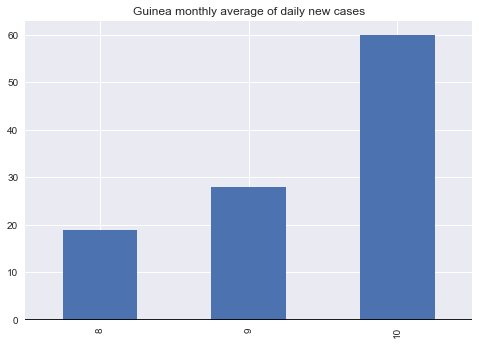

Daily new deaths[9.3333333333333339, 15.0, 50.0]


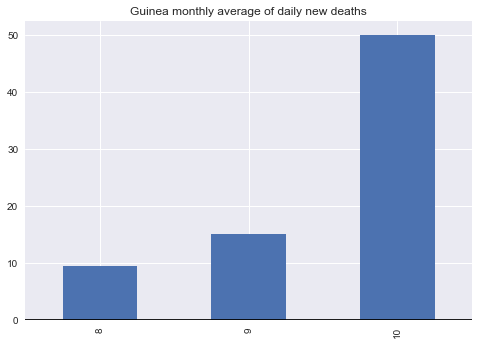

In [13]:
averagesCases=calculateAverageCumul(month_dfs,listCase)
averagesDeaths=calculateAverageCumul(month_dfs,listDeath)
guineaSeriesCases=pd.Series(data=averagesCases,index=months)
guineaSeriesDeaths=pd.Series(data=averagesDeaths,index=months)
import matplotlib.pyplot as plt

print('Daily new cases' +str(averagesCases))
guineaSeriesCases.plot(kind='bar'); plt.axhline(0, color='k')
plt.title('Guinea monthly average of daily new cases')
plt.show()


print('Daily new deaths' +str(averagesDeaths))
guineaSeriesDeaths.plot(kind='bar'); plt.axhline(0, color='k')
plt.title('Guinea monthly average of daily new deaths')
plt.show()


### PROCESSING LIBERIA

For Liberia we process the data the following way. <br>
The daily average per month of deaths will be extracted from the rows with description:<br>
'<i>Total death/s in confirmed, probable, suspected cases</i>'.The number of deaths is calculated based on the difference between two following dates. We do not sum <i>Total death/s in suspected cases</i>', '<i>Total death/s probable cases</i>', '<i>Total death/s confirmed cases</i>' because of note3. 
<br>


For the same reasons as Guinea the rows with description <i>'Total suspected cases'</i>,<i>'Total probable cases'</i>,<i>'Total confirmed cases'</i> are used. This works fine but some strange things appear in the data. From 2014-10-31 to 2014-11-02 suddently an extra 2000 confirmed cases appears which is impossible. Therefore we can use <i>'Cumulative confirmed, probable and suspected cases'</i> which is correct then, the only problem is that this data information appears somewhere during oktober.Therefore <i>'Total suspected cases'</i>,<i>'Total probable cases'</i>,<i>'Total confirmed cases'</i> is used untill october and after that  <i>'Cumulative confirmed, probable and suspected cases'</i> is used. 

<br>
<b>note3:</b> Some data is missing in the Liberia set. From 2014-10-07 on they stopped making a distinction beteen confirmed probable and suspected in deaths and just use the cumulative, therefore the cumulative is used.<br>
<b>note4:</b> From 2014-12-04 the columns new cases and total cases are interchanged, one more reason to go for the <i>'Cumulative confirmed, probable and suspected cases'</i>.

Daily new cases: [  10.42857143   21.23502304   83.45852535  140.55         95.06451613
   80.64285714   32.        ]


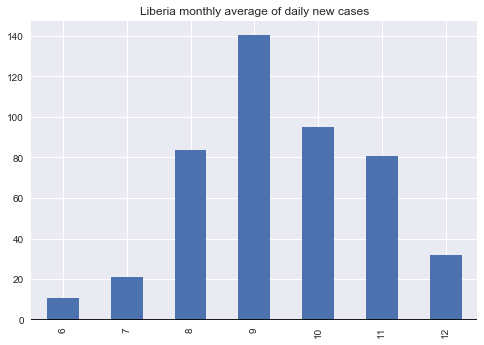

Daily deaths: [  6.14285714  10.96774194  48.33870968  72.25        41.22580645
  30.66666667  29.55555556]


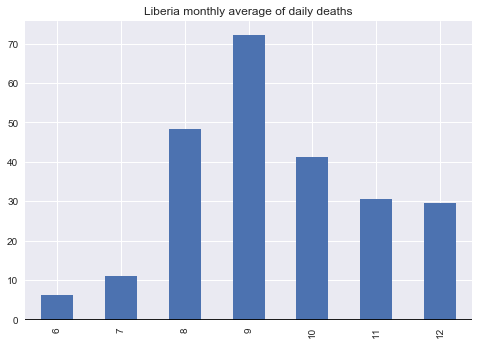

In [14]:

dataFrameLiberia= dataFrameGuinea=df.loc[('liberia')]
dataFrameLiberia.drop_duplicates(subset=['Description'])


listCase1=['Total suspected cases', 'Total probable cases', 'Total confirmed cases']
listCase2=['Cumulative confirmed, probable and suspected cases']
listDeath=['Total death/s in confirmed, probable, suspected cases']
month_dfs=[]
months=[]
for month, month_df in dataFrameGuinea.groupby(dataFrameGuinea.Date.dt.month):
    #for day,day_df in month_df.groupby(month_df.Date.dt.day):   
    #From one point on in the data an linebreak is inserted in the csv file. 
    month_df.Description=month_df.Description.str.replace('\n ?' , '')
    month_dfs.append(month_df)
    months.append(month)

#averagesCases=calculateAverage(month_dfs[0:len(month_dfs)-1],listCase)
averagesDeaths=calculateAverageCumul(month_dfs,listDeath)
#First part of the data, still with listCase1
averagesCases=calculateAverageCumul(month_dfs[0:len(month_dfs)-2],listCase1)
#Second part of the data is processed with listCase2
averagesCases2=calculateAverageCumul(month_dfs[len(month_dfs)-2:],listCase2)
[averagesCases.append(av) for av in averagesCases2]                               
                        


liberiaSeriesDeaths=pd.Series(data=averagesDeaths,index=months)
liberiaSeriesCases=pd.Series(data=averagesCases,index=months)

print('Daily new cases: ' + str(liberiaSeriesCases.values))
liberiaSeriesCases.plot(kind='bar'); plt.axhline(0, color='k')
plt.title('Liberia monthly average of daily new cases')
plt.show()

print('Daily deaths: ' + str(liberiaSeriesDeaths.values))

liberiaSeriesDeaths.plot(kind='bar'); plt.axhline(0, color='k')
plt.title('Liberia monthly average of daily deaths')
plt.show()






### PROCESSING Sierra Leone
For sl the data is processed as follows. 
The new cases are found from the rows with description: '<i>new_suspected</i>','<i>new_probable</i>','<i>new_confirmed</i>'. A quick look at the data reveils that these are the new cases from that specific day. The average is calculated as the average of these numbers. It would also be possible to use the cummulative numbers but for educational purposes a different method is used. 

The deaths are calculated from '<i>death_suspected</i>', '<i>death_probable</i>' and '<i>death_confirmed</i>'. These are cumulative numbers and therefore the same method as with Guinea and Liberia can be used. However another problem rises: the sl data of death_confirmed is left empty alot while there are no other alternatives to use. This is why in preparing the data we used fillna(method='backfill') in preparing the data. 

Last date is left out because it contains no interesting data for calculating the deaths, also the new cases are not filled in there.




Daily new cases[51.8, 83.51724137931035, 142.85714285714286, 153.8095238095238, 102.5]


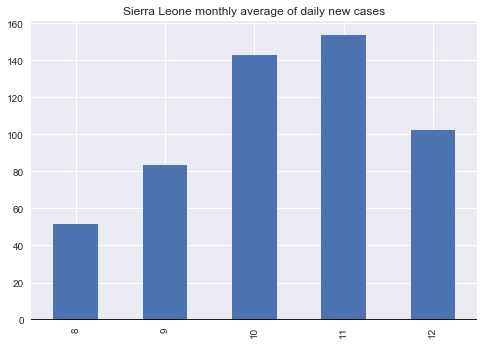

Daily new deaths[13.894736842105264, 10.266666666666667, 54.064516129032256, 30.233333333333334, 61.833333333333336]


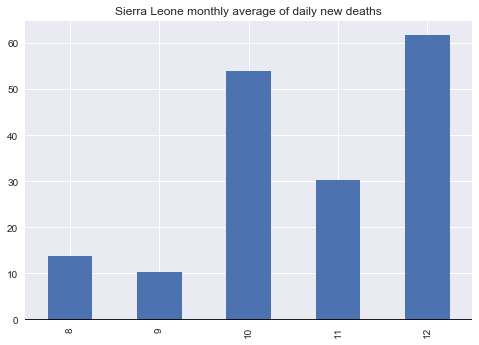

In [15]:
dataFrameSl=df.loc[('sl')]
#Remove the last date
dataFrameSl=dataFrameSl[dataFrameSl['Date']!='2014-12-13']
month_dfs=[]
months=[]
averagesCases=[]
listCases= ['new_suspected','new_probable','new_confirmed']
listDeaths=['death_suspected', 'death_probable', 'death_confirmed']
for month, month_df in dataFrameSl.groupby(dataFrameSl.Date.dt.month):
    month_dfs.append(month_df)
    months.append(month)
    averagesCases.append(averageNormal(month_df,listCases))
averagesDeaths=calculateAverageCumul(month_dfs,listDeaths)

slSeriesCases=pd.Series(averagesCases,months)
slSeriesDeaths=pd.Series(averagesDeaths,months)

print('Daily new cases' +str(averagesCases))
slSeriesCases.plot(kind='bar'); plt.axhline(0, color='k')
plt.title('Sierra Leone monthly average of daily new cases')
plt.show()


print('Daily new deaths' +str(averagesDeaths))
slSeriesDeaths.plot(kind='bar'); plt.axhline(0, color='k')
plt.title('Sierra Leone monthly average of daily new deaths')
plt.show()


There seems to be a weird unexplainable drop in the month of daily deaths in the month of november.


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [16]:
dataFrame = pd.DataFrame()
dataframe_array=[]
dataframe_array2=[]
path = DATA_FOLDER+'/microbiome/'
files = os.listdir(path)

#Listing all measurement files
files_xls = [f for f in files if f[-3:] == 'xls' and f!='metadata.xls']
#Importing the meta data into the dataframe 'meta'
meta = pd.read_excel(path+'metadata.xls', sheetname="Sheet1", header=None)
meta.fillna(value='unknown',inplace=True) 

for i, f in enumerate(files_xls):
    #Individually converting .xls measurement files into data frames and placing them into array "dataframe_array"
    dataframe_array += [pd.read_excel(path+f,sheetname="Sheet 1", header=None)]
    
    #Adding three leading empty columns to the each in each data frame in the array "dataframe_array2"
    add = pd.DataFrame(index=range(len(dataframe_array[i].index),3),columns=[0,1,2])
    dataframe_array2 += [pd.concat([add,dataframe_array[i]],axis=1,ignore_index=False)] 
    
    #Setting column names to ensure proper adressing
    dataframe_array2[i].columns =[0,1,2,3,4]
    
    #Placing the meta data into the empty leading columns
    dataframe_array2[i].loc[:,0] = meta.loc[i+1,0]
    dataframe_array2[i].loc[:,1] = meta.loc[i+1,1]
    dataframe_array2[i].loc[:,2] = meta.loc[i+1,2]
    
    #Concatinating all data frames from array "dataframe_array2" into the single data frame "DataFrame"
    dataFrame = dataFrame.append(dataframe_array2[i])

#Setting columns to proper names
dataFrame.columns =[meta.loc[0,0],meta.loc[0,1],meta.loc[0,2],'VARIETY','COUNT']        
    
#Resetting index to a unique running integer index
dataFrame.reset_index(drop=True,inplace=True)

#Alternative hierarchical unique index
df = dataFrame.set_index(['BARCODE','VARIETY'])

#Setting columns to proper names
dataFrame.columns =[meta.loc[0,0],meta.loc[0,1],meta.loc[0,2],'VARIETY','COUNT']    

#Replacing NaN/Na values in "DataFrame" with 'unknown'
dataFrame.fillna(value='unknown',inplace=True)


#Output of the hierarchical index version
df



GROUP  \
BARCODE VARIETY                                                                  
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Methanococci Methanococ...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Methanopyri Methanopyra...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Thermoplasmata Thermopl...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
...                                                                        ...   
MID9    Bacteria "Proteobacteria" Gammaproteobacteria O...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria O...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria O...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria X

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [17]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

**Q1)** Describe the type and the value range of each attribute. Indicate and transform the attributes that can be Categorical.

In [18]:
# Acquiring  data

df=pd.read_excel(open(DATA_FOLDER+'/titanic.xls','rb'))

df.sample(10)# random sample to display

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1288,3,0,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,NaN,S,NaN,314.0,NaN
1055,3,0,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S,NaN,NaN,NaN
752,3,0,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.1500,NaN,S,NaN,NaN,"West Bromwich, England Pontiac, MI"
596,2,1,"Wilhelms, Mr. Charles",male,31.0,0,0,244270,13.0000,NaN,S,9,NaN,"London, England"
1156,3,0,"Rosblom, Miss. Salli Helena",female,2.0,1,1,370129,20.2125,NaN,S,NaN,NaN,NaN
659,3,1,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C,C,NaN,"Syria New York, NY"
281,1,1,"Stengel, Mrs. Charles Emil Henry (Annie May Mo...",female,43.0,1,0,11778,55.4417,C116,C,5,NaN,"Newark, NJ"
979,3,0,"Lundahl, Mr. Johan Svensson",male,51.0,0,0,347743,7.0542,NaN,S,NaN,NaN,NaN
489,2,1,"Louch, Mrs. Charles Alexander (Alice Adelaide ...",female,42.0,1,0,SC/AH 3085,26.0000,NaN,S,NaN,NaN,"Weston-Super-Mare, Somerset"
653,3,1,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C,C,NaN,"Syria Youngstown, OH"


In [19]:
#Number of unique values in each column
df.apply(lambda x: len(x.unique())) 

pclass          3
survived        2
name         1307
sex             2
age            99
sibsp           7
parch           8
ticket        939
fare          282
cabin         187
embarked        4
boat           29
body          122
home.dest     370
dtype: int64

In [20]:
#Types of each column in dataframe
df.dtypes


pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [21]:
#Overll summary of categorical variables in dataframe
df.describe(exclude=[np.number])

,name,sex,ticket,cabin,embarked,boat,home.dest
count,1309,1309,1309,295,1307,486,745
unique,1307,2,939,186,3,28,369
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S,13,"New York, NY"
freq,2,843,11,6,914,39,64


In [22]:
#Overll summary of numerical variables in dataframe
df.describe(exclude=['O']).round(2)

,pclass,survived,age,sibsp,parch,fare,body
count,1309.00,1309.00,1046.00,1309.00,1309.00,1308.00,121.00
mean,2.29,0.38,29.88,0.50,0.39,33.30,160.81
std,0.84,0.49,14.41,1.04,0.87,51.76,97.70
min,1.00,0.00,0.17,0.00,0.00,0.00,1.00
25%,2.00,0.00,21.00,0.00,0.00,7.90,72.00
50%,3.00,0.00,28.00,0.00,0.00,14.45,155.00
75%,3.00,1.00,39.00,1.00,0.00,31.28,256.00
max,3.00,1.00,80.00,8.00,9.00,512.33,328.00


In [23]:
#Number of null values in each column
df.isnull().sum() 

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Feature transformation of variables (where it was required) was done in latter stage of data exploration

**Q2)** Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.

We can see that the Age, Cabin, boat, fare, embarked, body  and home.dest and Embarked columns have missing entries. It is required to find a way to populate or drop the missing values of the associated columns.

In [24]:
#Number of null values in age column
df["age"].isnull().sum()


263

There are missing entries in this column. The easiest option could be just drop the missing values or filling them up with 0. But since it is 263 values that are missing here, throwing them off is not a logical option. On the other hand, age can not be 0. The next alternative is to fill them up with median or mean. Yet in order to decide which estimation option is logical in current context, we need to visualize the distribution of the data first

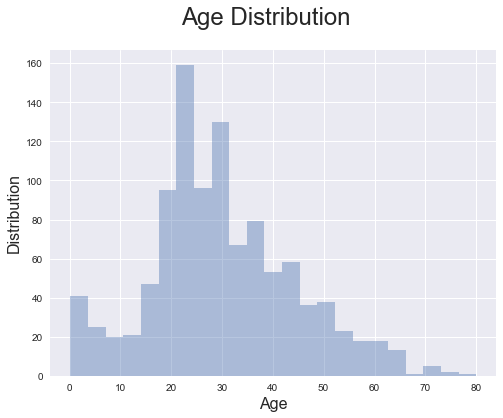

In [25]:
#Histogram of age distribution
f, ax = plt.subplots(figsize=(8, 6)) 

fig=sns.distplot(df['age'].dropna(),kde=False) # Plotting age distribution
fig.figure.suptitle("Age Distribution", fontsize = 24) #Chart title

plt.xlabel('Age', fontsize=16) #Lebel of x axis
plt.ylabel('Distribution', fontsize=16) # Lebel of y axis
plt.show()


From the histogram, It is clear that ages between 20 and 30 are the most common, so filling in missing values with  median could probably reasonable.

In [26]:
#Checking age feature's overall satistical summary
new_age= df['age'].fillna(df['age'].median())
df["age_transformed"] = new_age
df["age_transformed"].describe()


count    1309.000000
mean       29.503183
std        12.905246
min         0.166700
25%        22.000000
50%        28.000000
75%        35.000000
max        80.000000
Name: age_transformed, dtype: float64

 Let's look at the histogram again for a sanity check. The bar representing 28 is expected to be much taller this time.

In [27]:
df['age'].median() #median age

28.0

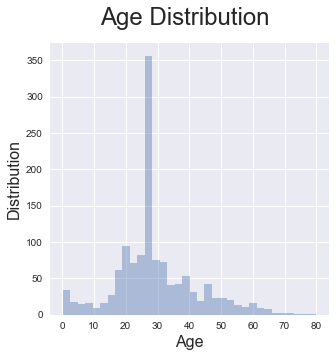

In [28]:

f, ax = plt.subplots(figsize=(5, 5))

fig=sns.distplot(df['age_transformed'],kde=False)
fig.figure.suptitle("Age Distribution", fontsize = 24) #Chart title

plt.xlabel('Age', fontsize=16) #Lebel of x axis
plt.ylabel('Distribution', fontsize=16) # Lebel of y axis
sns.plt.show()


In [29]:
# So let's add a title column to each DataFrame
# we also make a list of all our frames, such that we can easily loop over them.
def get_titles():

    df['title']='Unknown'
    # we extract the title from each name
    df['title'] = df['name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
    # we map each title
    df['title'] = df.title.map(Title_Dictionary)
    df['title'].value_counts()
get_titles()

In [30]:
# Let's check which titles are missing age data
df[np.isnan(df["age"])].title.unique()

array(['Mr', 'Officer', 'Mrs', 'Miss', 'Master'], dtype=object)

Only 5 types of titles that are missing age data. We can fill out those missing values of age based on the median filtered by title .




In [31]:
# Assigning the missing age to the median age with the given title.
frames = [df]
for t in df[np.isnan(df["age"])].title.unique():
            for df in frames: df.loc[(df["title"]==t) & np.isnan(df["age"]), "age" ] = df[df["title"]==t].age.median()


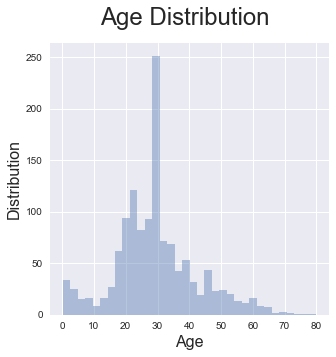

In [32]:
f, ax = plt.subplots(figsize=(5, 5))

fig=sns.distplot(df['age'],kde=False)
fig.figure.suptitle("Age Distribution", fontsize = 24) #Chart title

plt.xlabel('Age', fontsize=16) #Lebel of x axis
plt.ylabel('Distribution', fontsize=16) # Lebel of y axis
sns.plt.show()

It is probabably still not good enough, but it seems better option than just filling out median of all ages

In [33]:
# Passenger class mapping to categorical 
Pclass_map = {1: '1st Class', 2: '2nd Class', 3: '3rd Class'}
df['pclass_category'] = df['pclass'].map(Pclass_map)
df['pclass_category'].sample(10)

247     1st Class
118     1st Class
1007    3rd Class
981     3rd Class
451     2nd Class
384     2nd Class
701     3rd Class
1065    3rd Class
817     3rd Class
218     1st Class
Name: pclass_category, dtype: object

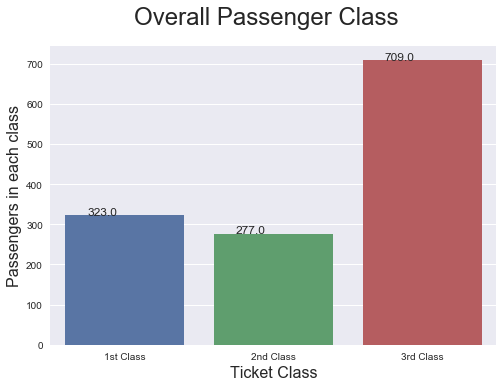

In [34]:
#Plotting passenger class chart
fig=sns.countplot(df['pclass_category']);
fig.figure.suptitle("Overall Passenger Class", fontsize = 24) #Chart title

plt.xlabel('Ticket Class', fontsize=16) #Lebel of x axis
plt.ylabel('Passengers in each class', fontsize=16) # Lebel of y axis
label_ = df.pclass
for p in fig.patches:
    fig.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
     
sns.plt.show()


In [35]:
#Converting catgorical embarked column to dummy
df_embark= pd.get_dummies(df['embarked'])

In [36]:
#Checking null values
pd.value_counts(df['embarked'].isnull())


False    1307
True        2
Name: embarked, dtype: int64

In [37]:
# Replacing missing values with most common port in the column
df.embarked[ df.embarked.isnull() ] = df.embarked.dropna().mode().values


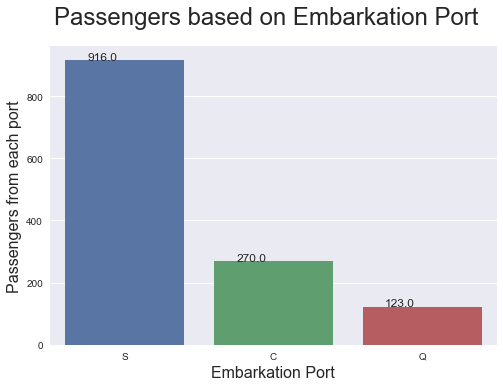

In [38]:
fig=sns.countplot(df['embarked']);
fig.figure.suptitle("Passengers based on Embarkation Port", fontsize = 24) #Chart title

plt.xlabel('Embarkation Port', fontsize=16) #Lebel of x axis
plt.ylabel('Passengers from each port', fontsize=16) # Lebel of y axis
label_ = df.pclass
for p in fig.patches:
    fig.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
     
sns.plt.show()


**Q3)** Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.


In [39]:
df["floor"] = "Unknown" # intitilaizing new column named floor
df.loc[pd.notnull(df["cabin"]), "floor"] = df["cabin"].str[0] #Filtering values from each cabin Number string
df["cabin"].head(5)

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object

It is not as expected, it requires cleaning again

In [40]:
#Cabin String wiith more 5 characters
df.loc[df.cabin.str.len() == 5,:]


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_transformed,title,pclass_category,floor
605,3,1,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,F G63,S,A,NaN,"Perkins County, SD",25.0,Mr,3rd Class,F
873,3,0,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,348121,7.6500,F G63,S,NaN,120.0,NaN,42.0,Mr,3rd Class,F
941,3,1,"Krekorian, Mr. Neshan",male,25.0,0,0,2654,7.2292,F E57,C,10,NaN,NaN,25.0,Mr,3rd Class,F
994,3,0,"Mardirosian, Mr. Sarkis",male,29.0,0,0,2655,7.2292,F E46,C,NaN,NaN,NaN,28.0,Mr,3rd Class,F
1024,3,0,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S,NaN,309.0,NaN,25.0,Mr,3rd Class,F
1122,3,1,"Peter, Miss. Anna",female,22.0,1,1,2668,22.3583,F E69,C,D,NaN,NaN,28.0,Miss,3rd Class,F
1217,3,0,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.6500,F G73,S,NaN,NaN,NaN,19.0,Mr,3rd Class,F


In [41]:
#Converting 5 Character strings to 3 Characters
df.loc[pd.notnull(df["cabin"]) & (df.cabin.str.len() == 5), "floor"] = df["cabin"].str[2]

In [42]:
#Number of values in floor column
df.floor.value_counts()

Unknown    1014
C            94
B            65
D            46
E            44
A            22
F            14
G             9
T             1
Name: floor, dtype: int64

In [43]:
#Percentage of passengers in each floor

percent_passenger=100. * df.floor.value_counts() / len(df.floor)
percent_passenger.round(2).astype(str) + '%'

Unknown    77.46%
C           7.18%
B           4.97%
D           3.51%
E           3.36%
A           1.68%
F           1.07%
G           0.69%
T           0.08%
Name: floor, dtype: object

There is no clue what cabin T is supposed to mean, but there was a place in Titanic named Tank Top. It is assumed here that T represents tank top here and there was one person lived there

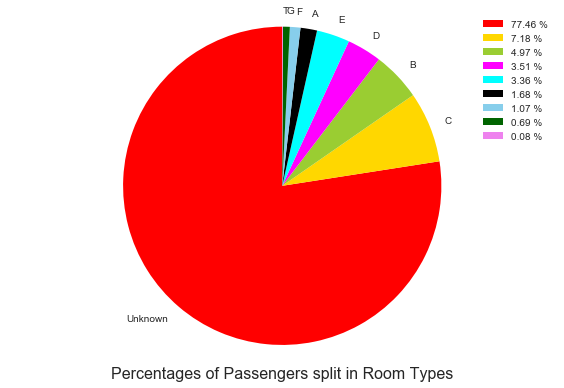

In [46]:
labels=['Unknown','C','B','D','E','A','F','G','T']
x = np.char.array(['Unknown','C','B','D','E','A','F','G','T'])

percent = percent_passenger
colors = ['red','gold','yellowgreen','magenta','cyan','black','skyblue', 'darkgreen','violet']

patches, texts = plt.pie( percent_passenger,colors=colors,labels=x,radius=1.2, startangle=90)
sort_legend = True

plt.legend(patches, labels, loc="best")

labels = ['{1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

plt.legend(patches, labels,loc='left center',fontsize=10)
fig.figure.suptitle("Passengers based on Gender", fontsize = 24) #Chart title

plt.xlabel('Percentages of Passengers split in Room Types', fontsize=16) #Lebel of x axis
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()



**Q4)** For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

In [48]:
fractions={}
for className, class_df in df.groupby(df.pclass):
    survival_by_class=np.sum(class_df['survived'])
    total_by_class=len(class_df)
    fractionSurvived=survival_by_class/total_by_class
    fractions[className]=fractionSurvived
fractions




{1: 0.6191950464396285, 2: 0.4296028880866426, 3: 0.2552891396332863}

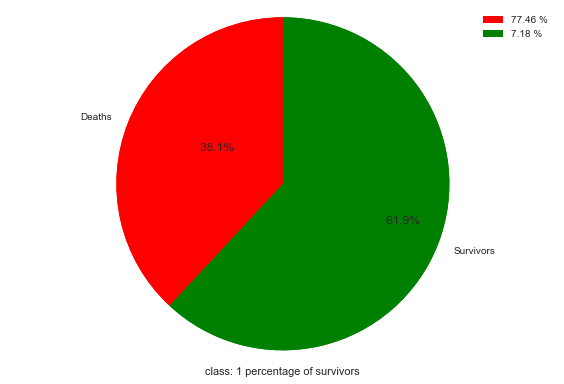

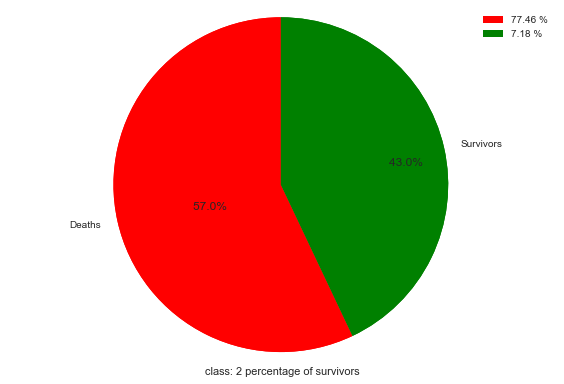

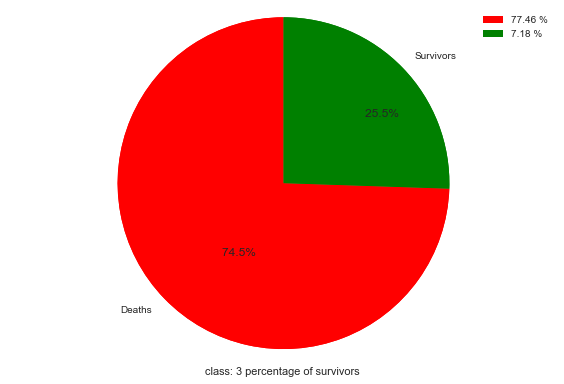

In [49]:
for key in fractions.keys():
    surv=[1-fractions[key],fractions[key]]
    x=np.char.array(['Deaths','Survivors'])
    plt.pie(surv, colors=['red','green'],autopct='%20.1f%%',labels=x, startangle=90)
    patches, texts = plt.pie(surv, colors=['red','green'], startangle=90)
    plt.legend(patches, labels, loc="best")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.xlabel('class: '+str(key) +' percentage of survivors')
    plt.tight_layout()
    plt.show()

Another interesting thing would be to now the share of survivors split by class.

In [50]:
# Draw different classes's survive rate detail
class_sex_group = df['pclass'].where(df['survived']==1)
class_sex_survive_prec = class_sex_group.mean()
survival_by_class=100. * df.pclass.where(df['survived']==1).value_counts()/ len(df[df['survived']==1])
survival_by_class.round(2).astype(str) + '%'


1.0    40.0%
3.0    36.2%
2.0    23.8%
Name: pclass, dtype: object

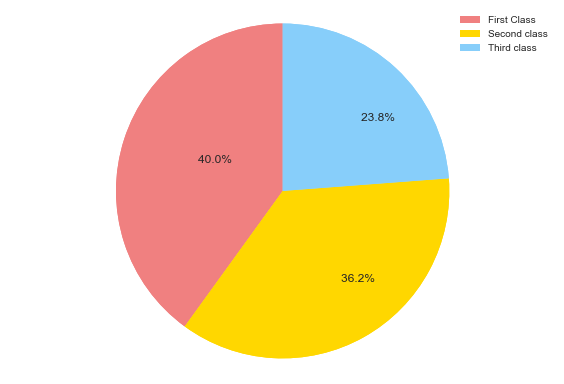

In [51]:
# Drawing different classes's survive rate detail

labels = ['First Class', 
'Second class', 'Third class']
colors = ['lightcoral', 'gold', 'lightskyblue']



plt.pie(survival_by_class, colors=colors,autopct='%20.1f%%', startangle=90)
patches, texts = plt.pie(survival_by_class, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()

**Q5**Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.


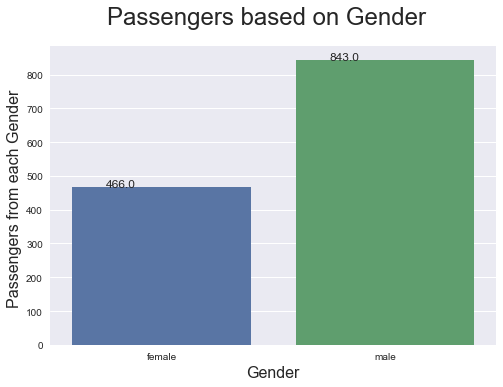

In [52]:
#transformation of gender column
genders = {"male": 1, "female": 0}
fig=sns.countplot(df['sex']);
fig.figure.suptitle("Passengers based on Gender", fontsize = 24) #Chart title

plt.xlabel('Gender', fontsize=16) #Lebel of x axis
plt.ylabel('Passengers from each Gender ', fontsize=16) # Lebel of y axis
label_ = df.pclass
for p in fig.patches:
    fig.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show() 

In [53]:
#Calculating proportion of survival based on sex and ticket class
class_sex_group = df[['sex','pclass','survived']].groupby(['sex','pclass'],as_index=False)
class_sex_survive_prec = class_sex_group.mean()

class_sex_survive_prec['survived']=class_sex_survive_prec['survived'].round(2)
class_sex_survive_prec

,sex,pclass,survived
0,female,1,0.97
1,female,2,0.89
2,female,3,0.49
3,male,1,0.34
4,male,2,0.15
5,male,3,0.15


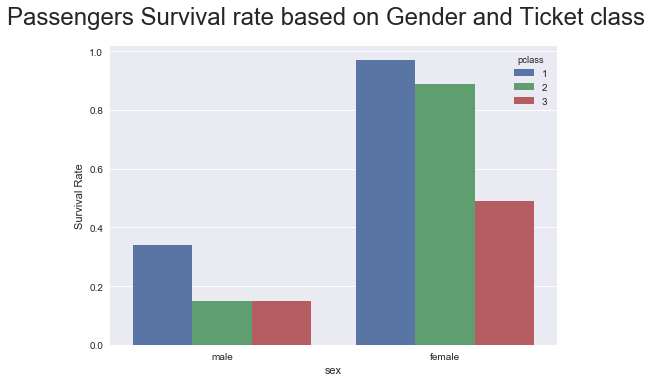

In [54]:
#Plotting the result
fig = sns.barplot(data=class_sex_survive_prec, x='sex',y='survived',hue='pclass',order=['male','female'])
fig.axes.set_ylabel('Survival Rate')
fig.figure.suptitle("Passengers Survival rate based on Gender and Ticket class", fontsize = 24) #Chart title


plt.show()

Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.


In [55]:
#Transforming age feture
df['age_category'] = df['age'].apply(lambda x: "Child" if x <= 10 else "Adult")
df['age_category']=df.query('survived==1')['age_category']
df['age_category'].dropna().sample(5)

261     Adult
862     Adult
1000    Adult
13      Adult
514     Child
Name: age_category, dtype: object

In [56]:
#Displaying result in dataframe
age_distribution= df.groupby(["age_category", "pclass","sex"]).agg({'age_category': lambda x: 100. *x.count()/len(df['age_category'])})
age_distribution.round(2).astype(str) + '%'

age_category
age_category pclass sex                
Adult        1      female       10.62%
                    male          4.43%
             2      female        6.34%
                    male          1.07%
             3      female        7.03%
                    male          4.66%
Child        1      male          0.23%
             2      female        0.84%
                    male          0.84%
             3      female        1.07%
                    male          1.07%